# Message Passing
Given a network with labels on some nodes, how to assign labels to all other nodes in the network? Whereas before node-embedding was used; now an alternative framework, **message passing**, will be used. This will have nodes update their own idea of what their label is based on their neighbours' labels (similar to PageRank, etc.). This is based on the intuition that individual node behaviours are correlated in the network (nearby nodes will have the same label); due to homophily (tendency of individuals to associate and bond with similar others) and influence (social connection influence individual characteristics) dependencies of graphs.

Based on thes correlations; classificaiton label of a node $v$ in the netwrok may depend on $v$'s features, the labels of $v$'s neighbours, the features of $v$'s neighbours (guilt-by-association).

## Relational Classification
Class probability $Y_v$ of node $v$ is a weighted average of class probabilities of its neighbours (unlabeled nodes initialize $Y_v=0.5$). After initialisation, update all nodes in a random order until convergence (or until maximum number of iterations reached). $$\mathbb{P}(Y_v=c)=\frac{1}{\sum_{(v,u)\in E}A_{v,u}}\sum_{(v,u)\in E}A_{v,u}\mathbb{P}(Y_u=c)$$ If edges have strength/weight information $A_{v,u}$ (edge weight between $v$ and $u$). There are chanellenges with this model; namely that convergence is not guaranteed, and that the model cannot use node feature information.

## Iterative Classification
Building on relational classifier, iterative classification trains 2 classifiers; $\phi_1(f_v)$ to predict node label based on node feature vector $f_v$, and $\phi_2(f_v,z_v)$ to predict node label based on node feature vector $f_v$ and summary $z_v$ (histogram of each label, most common label, number of different labels, etc. in $N(v)$) of labels of $v's$ neighbours, $N(v)$. The architecture is then set up in two phases:

1. **Classify based on node attributes alone**: On the training set, train classifiers (linear classifier, neural network, etc.)
    - $\phi_1(f_v)$ to predict $Y_v$ based on $f_v$
    - $\phi_2(f_v,z_v)$ to predict $Y_v$ based on $f_v$ and summary $z_v$ of labels of $v$'s neighbours.
2. **Iterate until convergence**: On the test set, for each node in graph; initialise $Y_v$ based on the classifier $\phi_1$, compute $z_v$, and predict the updated labels with $\phi_2$. Iteratively re-compute $z_v$ and $Y_v$ (now only with $\phi_2$) until class labels stabilize (or max iteration is reached).

Here too, convergence is not guaranteed.

## Belief Propogation
Belief propogation is a dynamic programming approach to answer probability queries in a graph (probability of node $u$ belonging to class $1$); where iteratively neighbour nodes 'talk' and pass messages to each other. Once a consensus is reached, the final *belief* is calculated.
This can be formally defined as $$m_{i\rightarrow j}(Y_j) = \sum_{Y_i\in\mathcal{L}}\psi(Y_i,Y_j)\phi(Y_i) \prod_{k\in N(i) / \{j\}} m_{k\rightarrow i}(Y_i),\;\forall Y_j \in\mathcal{L}$$ where the **label-label potential matrix**, $\psi$, captures the dependencies between a node and its neighbour ($\psi(Y_i,Y_j)$ is proportional to the probability of a node $j$ being in class $Y_j$ given that it has neighbour $i$ in class $Y_i$ - if graph is homophily then will have high values on the diagonal), $\phi(Y_i)$ (**Prior belief**) is proportional to the probability of node $i$ being in class $Y_i$, $m_{i\rightarrow j}(Y_j)$ being node $i$'s message/estimate of $j$ being in class $Y_j$; and $\mathcal{L}$ is the set of all classes.
This iterative calculation (with initialized messages being $1$) will eventually converge, and node $i$'s belief of being in class $Y_i$ could then be calculated via $b_i(Y_i)=\phi(Y_i)\prod_{j\in N(i)} m_{j\rightarrow i}(Y_j),\;\forall Y_j \in\mathcal{L}$.

This process (in practice) is still run even when the graph is not acyclical (messages from different subgraph are no longer independent); though it will may mean that beliefs will not converge (loops can reinforce incorrect prior beliefs).

## Correct & Smooth
While Relational Classification performs well due to its homophily assumption, and is fast to compute, it does not use any additional information or features to determine the node labels. Graph Neural Networks on the other hand (will be explored in the future) are slower (require may parameters, irregular computations, etc.) to compute and train, and can achieve very good performances by only depending on neighborhood features to generate node labels (no assumption of correlation) when those features are predictive of result (catastrophic otherwise). Therefore, C&S attempts to bridge the gap between GNNs, and RCs and in doing so gain their individual benefits and mitigate each other's limitations. More information at https://arxiv.org/pdf/2010.13993. 

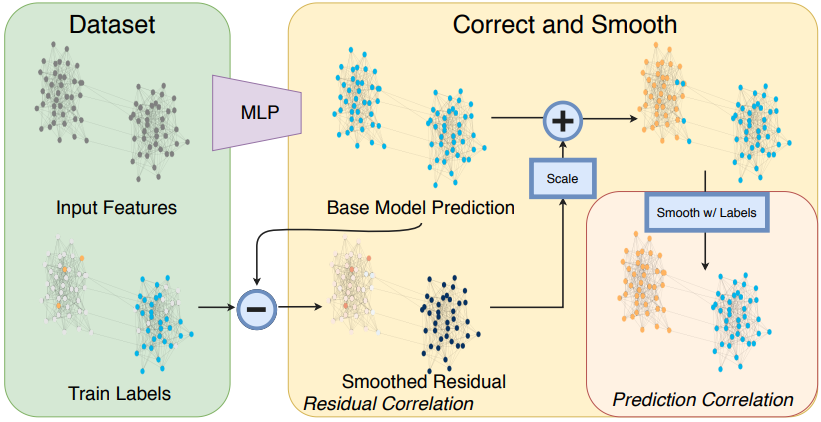

It does so by training a base predictor (linear, multi-layer-preceptron, gnn, etc.) and using it to generate "soft labels" (class probabilities) of all (with or without labels) nodes (labeled nodes are used to training/validation data); and then post-process these predictions using the graph structure to obtain the final labels of all nodes. The post-processing step is made out of 2 inner steps:

### Correct Step
The correction step is based on the idea that errors in the base prediction are positively correlated along edges in the graph (an error at node $u$ increases the chance of a similar error at neighbors of $u$), and so should "spread" such uncertainty over the graph. Therefore, after computing the initial training errors (ground-truth label *minus* soft label, defined as $0$ for unlabeled nodes) $E^{(0)}$ of nodes, diffusion of those training errors is taken place along the edges $E^{(t+1)}=(1-\alpha)E^{(t)}+\alpha\tilde{A}E^{(t)}$ (similar to PageRank) where $\alpha$ is a hyperparameter, $A$ is the adjacency matrix, and $\tilde{A}=D^{-1/2}AD^{-1/2}$ is its *diffusion matrix* ($D\equiv\text{Diag}(d_1,\ldots,d_N)$ be the degree matrix).
- This formulation of the diffusion matrix is used because all $\lambda$s' are in the range $[-1,1]$ and given that $1$ here is an all-one vector, $\tilde{A}D^{1/2}1=D^{-1/2}AD^{-1/2}D^{1/2}1=D^{-1/2}A1$ and since $A1=D1$ (both result in node degree vectors) $D^{-1/2}A1=D^{-1/2}D1=D^{1/2}1$ and so $D^{1/2}1$ is a guaranteed eigenvector with $\lambda=1$. Further, $\tilde{A}^k$ are all "well-behaved" for any $k$ (same characteristics as mentioned for $\tilde{A}$), and the output $\tilde{A}x$ (error diffusion) is normalized. Intuatively, if $i$ and $j$ are connected, the weight $\tilde{A}_{i,j}=\frac{1}{\sqrt{d_i}\sqrt{d_j}}$ which is **large** if $i$ and $j$ are only connected to each other and no other node is connected to either of them, adn **small** if $i$ or $j$ are connected also with other nodes.

This error propogation is continued until convergence occurs, afterwhich the "soft labels" and the "diffused training errors" (scaled by a hyperparameter $s$) are aggregated together to create the correct step output. 

### Smooth Step
This step smoothen the corrected "soft labels" along the edges (assume neighboring nodes tend to share the same label - homophily). It takes the corrected labels with ground-truth for the labeled nodes $Z^{(0)}$, and iteratively diffuse the labels vai $Z^{(t+1)}=(1-\alpha)Z^{(t)}+\alpha\tilde{A}Z^{(t)}$ (same as corrected step with different initial labels). The final class prediction is the class with the maximum $Z^{(t)}$ score ($Z^{(t)}$ score does not have direct probabilistic interpretation but larger scores indicate the classes are more likely).

# Graph Neural Network (GNN)
Assuming a graph $G$, with vertex set $V$, adjacency matrix $A$ (binary), node features $X\in\mathbb{R}^{m}\times\mathbb{R}^{|V|}$, and node neighbourhood $N(v),\;v\in V$; a naive approach would be to concatonate $A$ and $X$ together and feed it straight into a deep neural network. This however, is sensitive to node ordering, is not applicable to graphs of different sizes, and would require learning $O(|V|)$ parameters; thereby is not an ideal solution.

Using the prespective of an image being a strict lattice graph, some sort of (generalized) convolutional neural network may be designed to capture a general graph instead. With a traditional convolution layer, there is no fixed notion of locality (window) or transition (sliding) for a generic graph; also, as a graph does not have a canonical ordering of nodes it means that convolutional neural networks will not be a *permutation invariant/equivariant* function:

- A graph function $f:(\mathbb{R}^{|V|}\times\mathbb{R}^{|V|}, \mathbb{R}^{|V|}\times\mathbb{R}^{m})\rightarrow \mathbb{R}^{d}$ is ***permutation invariant*** if $f(A,X)=f(PAP^T,PX)$ for any permutation $P$.
- A **node** function $f:(\mathbb{R}^{|V|}\times\mathbb{R}^{|V|}, \mathbb{R}^{|V|}\times\mathbb{R}^{m})\rightarrow \mathbb{R}^{|V|}\times\mathbb{R}^{d}$ is ***permutation equivariant*** if $Pf(A,X)=f(PAP^T,PX)$ for any permutation $P$.

So instead of a sliding window, a convolutional layer is thought of as combining transformed neighbour information $h_i = \sum_{j \in N(i)}w_jh_j$, and doing so iteratively across the whole graph. A GNN *convolutional layer* (node embedding) can then be defined by determining a node of interest's **computation graph** (local network neighbourhood) and propograte/transform information from it back to compute the node features (embedding).

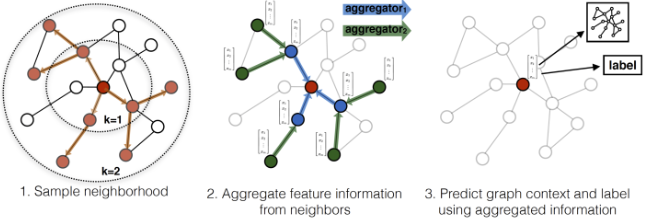

Doing so would generate a unique computation graph for each node $v$, with nodes having embeddings at each layer such that layer $k$ embeddings gets information from $N_k(v)$ (nodes which are $k$ hops away), such that if node $i\subseteq N_{k-1}(v)$, then it would get information only from $N_1(i)\subseteq N_k(v)$.

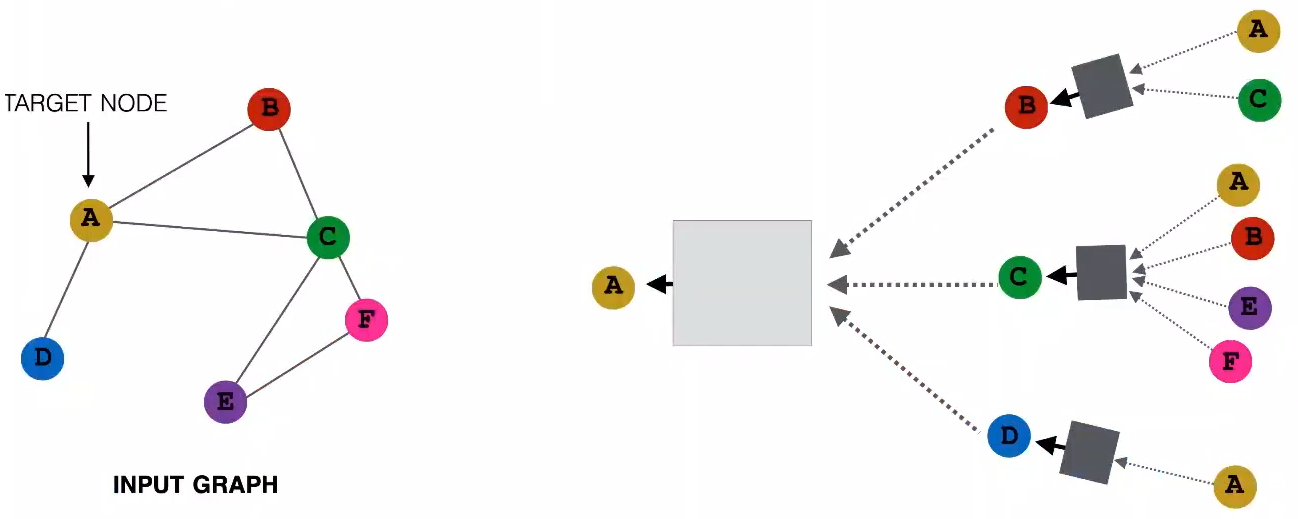

Each GNN layer then consists of; a **Message operator** which transforms a node's embedding at layer $l+1$ to a 'message' , $m_u^{(l)}=\text{MSG}^{(l)}(h_u^{(l+1)})$,for later use by other nodes, and an **Aggregation operator** which will form a single embedding (regardless of input ordering) of a node at layer $l$ from it's neighbours' messages $h_v^{(l)}=\text{AGG}^{(l)}(\{m_u^{(l)}, u\in N_1(v)\})$ (aggregation operator $f$ needs to be permutation invariant $\text{sum}(\cdot)$, $\text{mean}(\cdot)$, $\text{max}(\cdot)$, etc.).

In here, computation of $h_v^{(l)}$ does not directly depend on $h_v^{(l+1)}$, leading to the information from node $v$ itself possibly getting lost. And so a solution would be to to include $h_v^{(l+1)}$ in $h_v^{(l)}$'s computation:

1. Message - introduce a different message computation to be performed on $h_v^{(l+1)}$ only, $m_v^{(l)}=B^{(l)}h_v^{(l+1)}$.
2. Aggregation - after the neighbour aggregations, aggregate the message from node $v$ itself (via concatenation, summation, etc.), $h_v^{(l)}=\text{CONCAT}(\text{AGG}^{(l)}(\{m_u^{(l)}, u\in N_1(v)\}), m_v^{(l)})$.

Additionally, a non-linear activation function ($\sigma(\cdot)$) can be added to increase expressiveness of outputs ($\text{ReLU}(\cdot)$, $\text{Sigmoid}(\cdot)$, etc.).

## Graph Convolutional Network (GCN)
The classical approach would then be to average the neighbour messages (aggregation operator) and apply a neural network (transformation operator): $$h_{i}^{(k-1)}=\sigma(W^{(k-1)}\sum_{j\in N_1(i)}\frac{h_j^{(k)}}{|N_1(i)|}+B^{(k-1)}h_i^{(k)}),\;i\in N_{k-1}(v),\;h_i^{K}=\text{x}_i,\;\;\forall k\in\{K,\ldots,0\}$$ where the initial embedding $\text{x}_v^{(K)}$ is node $v$'s features, and the trainable parameters $W^{(k)}$ and $B^{(k)}$ are shared across the layer (not unique to $h_{i}^{(k)}$). These embeddings can be then fed into any loss function and be optimised through SGD.

- This additionally means that the GCB computation is permutation equivariant(embedding of a given node with GCN is invariant and so after permutation, the location of a given node in input node feature matrix would change but maintain its embedding value).

Furthermore, these aggregation and traqnsformation can be performed efficiently by (sparse) matrix operations: $$H^{(k)}=[h_1^{(k)},\ldots,h_{|V|}^{(k)}]^T\rightarrow\sum_{u\in N_1(v)}h_u^{(k)}=A_{(v,\,:)}H^{(k)}$$ $$D\in\mathbb{R}^{|V|}\times\mathbb{R}^{|V|}:D_{(v,v)}=d_v=|N_1(v)|\rightarrow D^{-1}\in\mathbb{R}^{|V|}\times\mathbb{R}^{|V|}:D^{-1}_{(v,v)}=1/|N_1(v)|$$ $$\therefore \sum_{u\in N_1(v)}\frac{h_u^{(k)}}{|N(v)|}=D^{-1}AH^{(k)}\rightarrow\;H^{(k-1)}=\sigma(\underbrace{\color{red} D^{-1}AH^{(k)}W_k^T \color{black}}_{\text{neighbour aggregation}}+\overbrace{\color{blue} H^{(k)}B_k^T \color{black}}^{\text{self transform}})$$
In practice, this implies that efficient sparse matrix multiplication can be used ($\tilde{A}=D^{-1}A$ is sparse). However, not all GNNs can eb expressed in a simple matrix form (when aggregation function is complex).

## GraphSAGE
$$h_v^{(l-1)}=\sigma(W^{(l-1)}\cdot\text{CONCAT}[h_v^{(l)}, \text{AGG}(\{h_u^{l},\forall u\in N_1(v)\})])$$
GraphSAGE builds on the GCN; extending it by maintaining an arbitrary aggregation operator (allows for multiple choices, not only average like in GCN), and concatonating the self-transform message with the aggregated neighbour messages (adds a lot of expressive power). 
Additionally, $L_2$ normalization can be optionally applied to $h_v^{(l)}$ at every layer ($||u||_2=\sqrt{\sum_iu_i^2}\rightarrow h_v^{(l)}=\frac{h_v^{(l)}}{||h_v^{(l)}||_2}$) to ensure its sum will always be 1 (without it, embedding vectors will have different scales). In some cases (not always), normalization of embedding results in performance improvement.

## Graph Attention Network (GAN)
$$h_v^{(l-1)}=\sigma(\sum_{u\in N_1(v)}\alpha_{vu}W^{(l-1)}h_u^{(l)})$$
This architecture builds on GCN by instead assigning equal importance to every neighbour of $v$ ($\frac{1}{|N_1(v)|}$), it defines an *attention weight* (inspired by cognitive attention), $\alpha_{vu}$, for each $u\in N_1(v)$ that is either explicitly based on structural properties of graph, or a learned parameter.

### Learned Attention Weight
Let $\alpha_{vu}$ be computed as a byproduct of an **attention mechanism** $a$ which computes **attention coefficients** $e_{vu}$ across pairs of nodes $u$, and $v$ based on their messages: $e_{vu}$ indicates the importance of $u$'s message to node $v$
$$e_{vu}=a(W^{(l-1)}h_u^{(l)},W^{(l-1)}h_v^{(l)})\rightarrow\alpha_{vu}=\frac{\exp{e_{vu}}}{\sum_{k\in N_1(v)}\exp{e_{vk}}}$$
Softmax is used to normalize $e_{vu}$ into the final attention weight so that $\sum_{u\in N_1(v)}\alpha_{vu}=1$.

the form of the attention mechanism (choice of $a$) is commonly a single-layer neural network ($a(\cdot,\cdot)=\text{Linear}(\text{Concat}(\cdot,\cdot))$), thereby is able to be trained jointly (due to chain-rule backpropogation) with the other trainable parameters of the model in an end-to-end fashion.

#### Multi-head Attention
While the normal attention mechanism is a good approach, in practice it can be difficult to work with due to instability (hard to make model converge). To overcome it, expanding the notion of attention can help to stabalize the learning process. This is done by creating multiple attention scores (each replica with a different set of parameters) $h_v^{(l-1)}[i]=\sigma(\sum_{u\in N_1(v)}\alpha_{vu}^iW^{(l-1)}h_u^{(l)})$ and have the outputs aggregated $h_v^{(l)}=\text{AGG}(\{h_v^{(l)}[i], i\in\{1,\ldots,n\}\})$ (concatenation, summation, etc.).

## Deep Learning Modules
In practice, better performance is achieved by considering a general GNN layer design which can utilise the above architectures together; additionally including modern deep learning modules that proved to be useful in other domains.

### Batch Normalization
Given a batch of inputs (embeddings), $X\in\mathbb{R}^N\times\mathbb{R}^D$, they can be re-centred and re-scaled , $\hat{X}_{i,j}=\frac{X_{i,j}-\mu_j}{\sqrt{\sigma_j^2+\epsilon}}\rightarrow Y_{i,j}=\gamma_j\hat{X}_{i,j}+\beta_j,\;\mu_j=\frac{1}{N}\sum_{i=1}^{N}X_{i,j},\;\sigma_j^2=\frac{1}{N}\sum_{i=1}^{N}(X_{i,j}-\mu_j)^2$ and $\gamma,\beta\in\mathbb{R}^D$ are trainable parameters, in order to stabalize the neural network training by preventing embedding/parametrs from exponentially increasing/decreasing in value.

### Dropout
During training, randomly zeroes some of the neurons (turn off) with some probability p (chosen independently for each forward call and are sampled from a Bernoulli distribution). This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons (overfitting). During testing all neurons are used for computation.
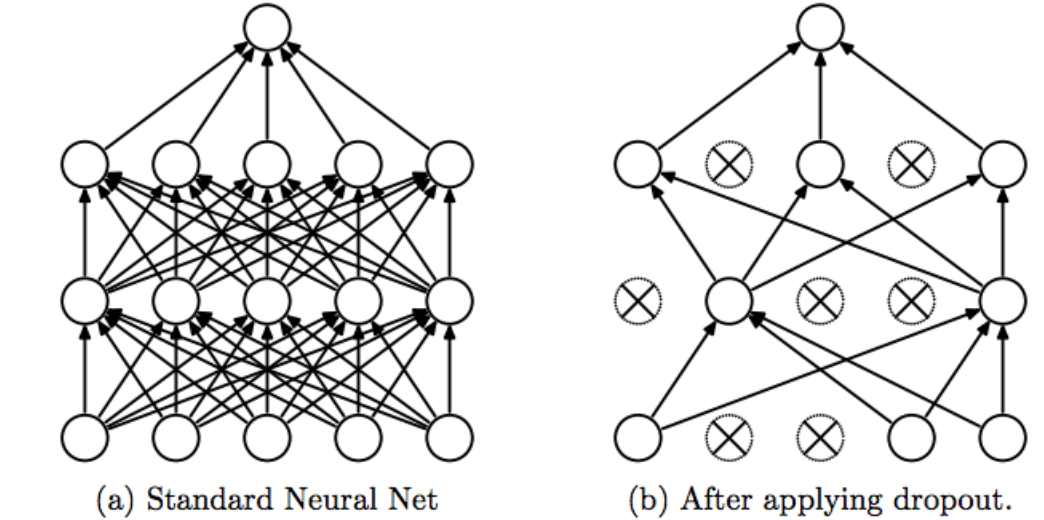
### GNN Layer Stacking
The standard method of adding complexity to a GNN model is to sequentially adding GNN layers (increase number of steps), there is a limit however on how many layers can be added; this is due to GNN suffering from the **over-smoothing problem** (all node embeddings converge to the same value), making it impossible to differentiate nodes. Over-smoothing occurs as each node's _receptive field_ (set of nodes that determine the embedding of a node of interest) become the same (receptive field overlap grows) as the number of hops (GNN layers) increase; as the embedding of a node is determined by its receptive field, it would mean that as the number of GNN layers increase, the nodes' receptive fields will become similar to each other (even when nodes are not similar) causing their embeddings to be also similar. Therefore be cautious when adding GNN layers, as unlike NNs in other domains adding more GNN layers does not always help; analyze the necessary receptive field (compute diameter of graph), and set the number of layers to be a bit more than it.
#### Expressive Power for Shallow GNNs
Whereas before the the Transformation and Aggregation functions only included one linear layer (matrix multiplication), these can be replaces with Multi-Layer-Perceptrons (MLP aka deep neural networks); thereby add expressiveness to the network without increasing the number of layers.

Alternatively (or additionally), **pre-processing** (important when encoding node features is necessary - images, text, etc.) and/or **post-processing** (important when reasoning/transformation over node embedding are needed - graph classification, knowledge graphs, etc.) layers (MLPs) can be added onto the GNN which do not pass messages; thereby prevent over-smoothing while increasing expressiveness (works great practically).

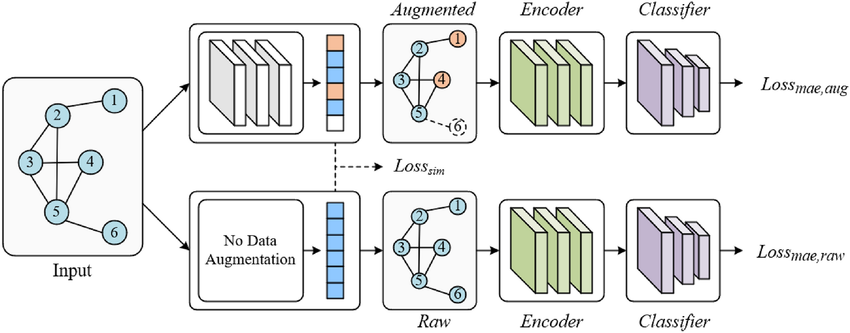

Furthermore, Adding skip connections in GNNs can increase expressiveness. From over-smoothing, it can be seen that node embeddings in earlier GNN layers can better differentiate nodes (sometimes); and so the impact of earlier layers on the final node embeddings can be icreased by adding shortcuts in the GNN, $h_v^{(l-1)}=h_v^{(l-1)}+h_v^{(l)}$. This method creates a mixture model (of shallow and deep GNNs) where $N$ skipp connections translate into $2^N$ possible paths (with each having upto $N$ modules). These skip connections do not have to skip a single layer (skip directly to the last layer).

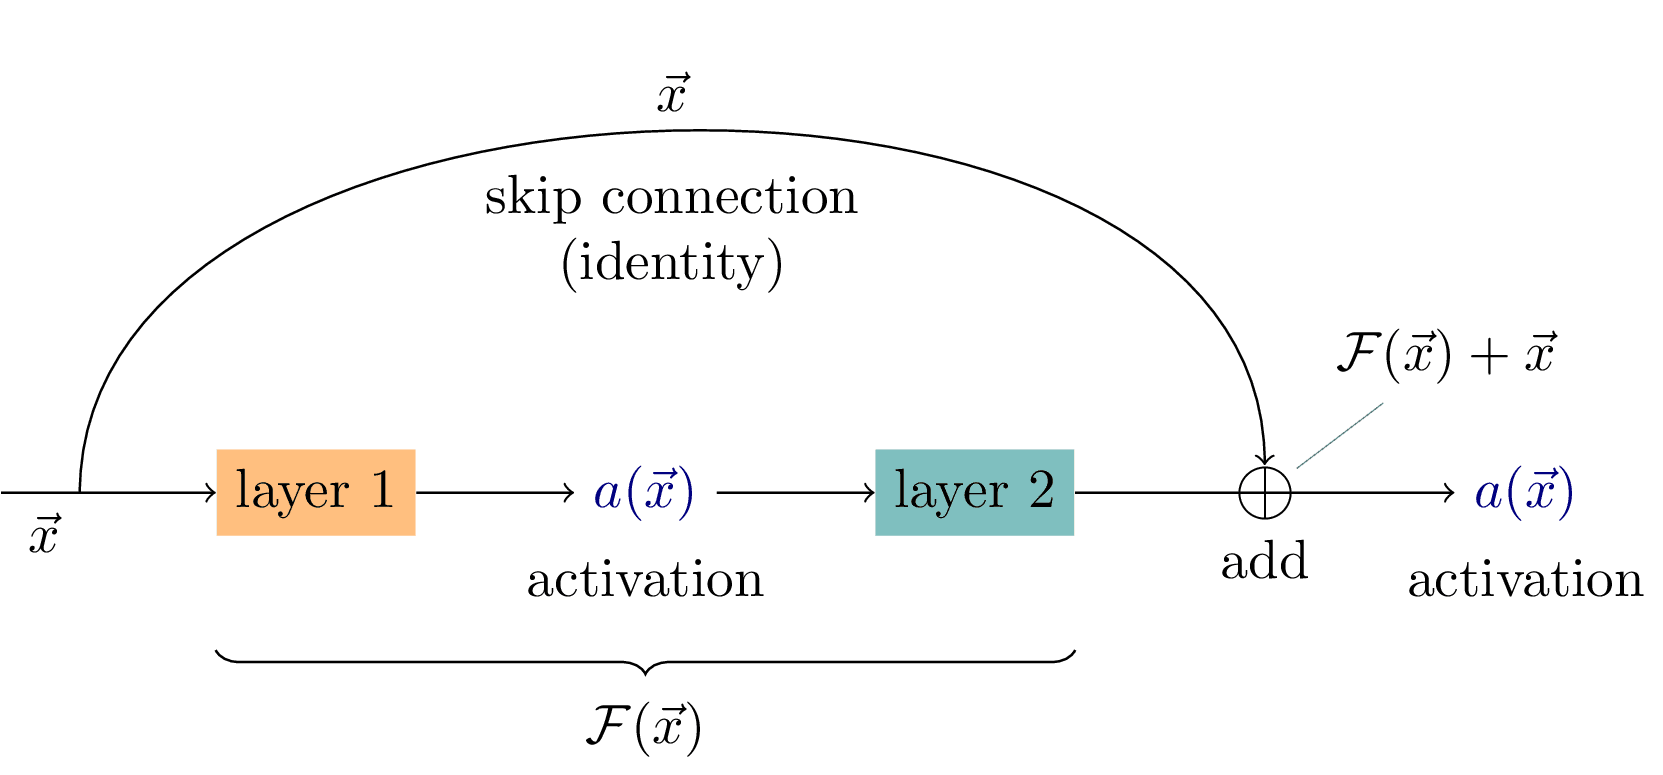

## Graph Augmentation for GNN
The general GNN frameworks is based on the assumption that the computation graph (base of GNN) is directly taken from the raw input graph. This assumption can be overturned to alleviate an input graph's lack of features, a graph that is too sparse (inefficient message passing), or dense (message passing too costly), or large (cannot fit computation graph into GPU); it is also unlikely that the input graph happens to be the optimal computation graph for embeddings, and thereby the breaking of this assumption can help improve model performance. 

### Graph Feature Augmentation (feature enrichment)
In situations where graph nodes do not have features (only adjacency matrix), the standard approaches for adding features is to assign either the **same constant** value (when set to 1, can be thought of counting $|N_l(v)|$), or a **unique identifier** (one-hot vector of arbitrary ordering as to not give rise to bias - note that this would be hard to generalise across different graphs) to every node in the graph. 

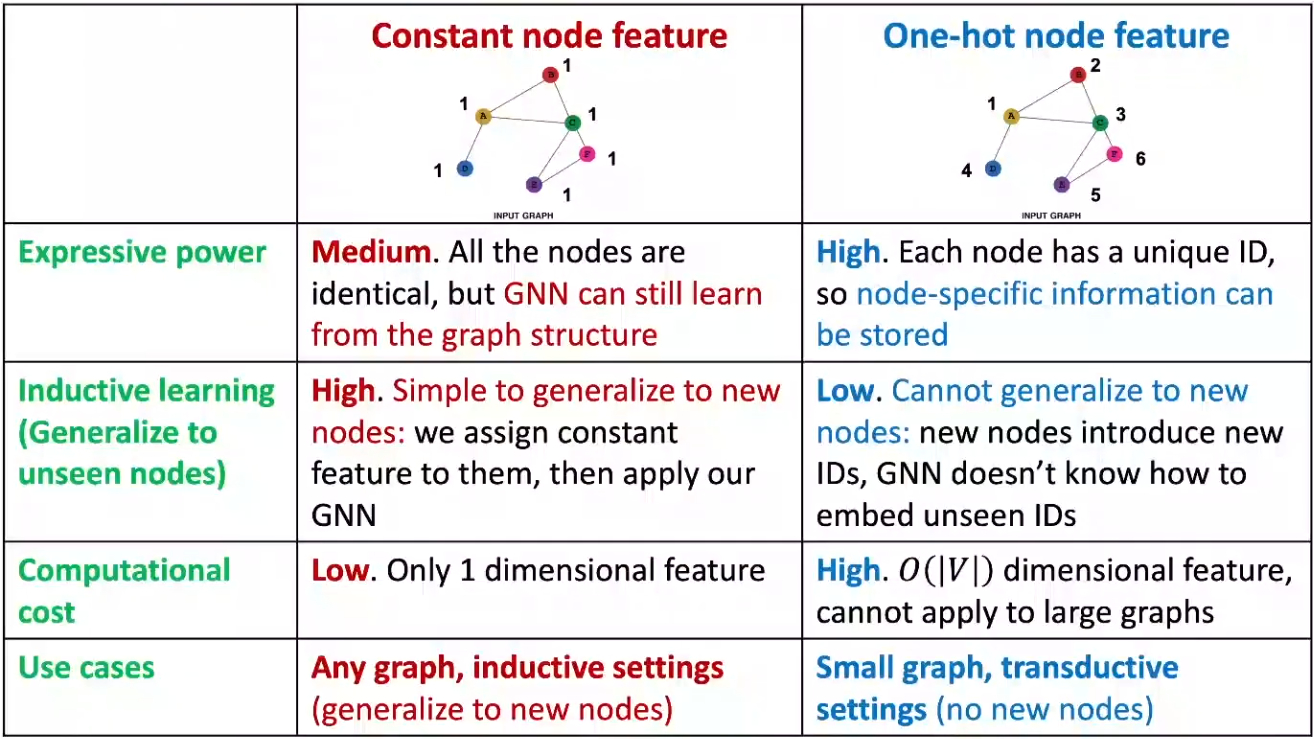

#### Structure Aware node features
Additionally, certain structures, like **cycle count** feature (task where GNN needs to learn the length of a cycles that a given node resides in), are hard to learn by a GNN (cycle of length 3 vs. 4 have the same computational graph structure for any given node) without discriminating node features. For this specific task assigning cycle counts as augmented node features (one-hot encoding - for cycles of length 3 assign $[0,0,0,1,\ldots]$) greatly improve performance; though other common augment features (node degree, clustering coefficient, PageRank, Centrality, etc.) can also be used.

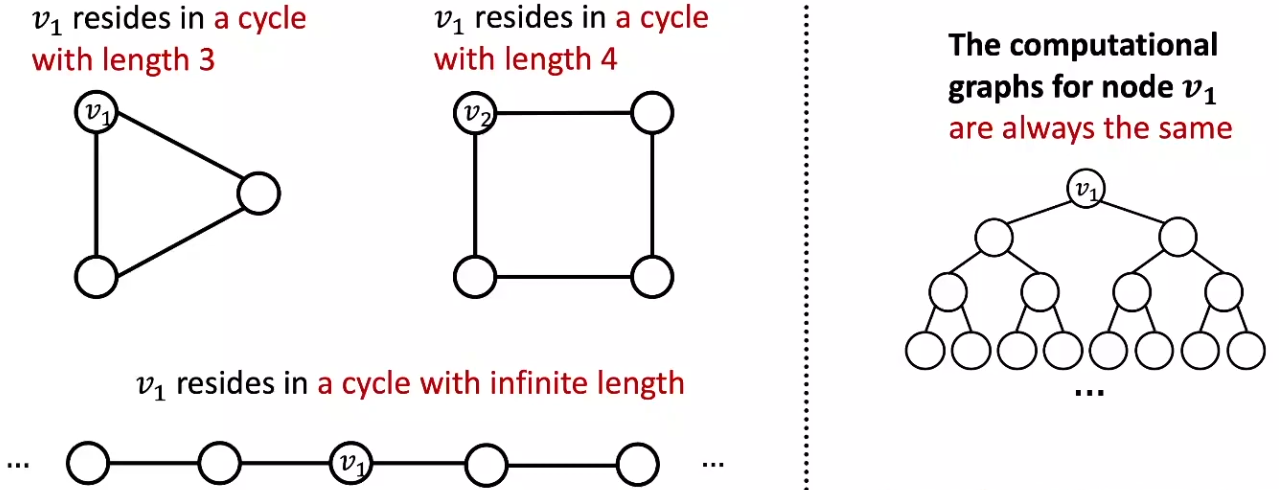

An improvement on cycle count for a given node, which only counts the closest or captures only the type (length of cycle), **closed loops count** correspond to the number of closed loops each node is invloved in, and can be easily calculated using $C^{(0)}=[\text{diag}(A^{0}),\text{diag}(A^{1}),\text{diag}(A^{2}),\ldots,\text{diag}(A^{D-1})]\in\mathbb{N}_0^N\times\mathbb{N}_0^D$. **"If two graphs have adjacency matrices with different eigenvalues, there exists a GNN with closed loop initial node features that can always tell them apart"**.

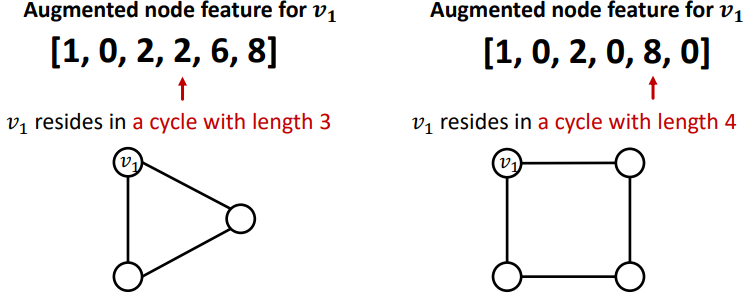

Emperically, GNNs with structural initial node features can produce different representations for almost all real-world graphs. *GIN* with structural initial node features is strickly more powerful than then *WL graph kernel*.

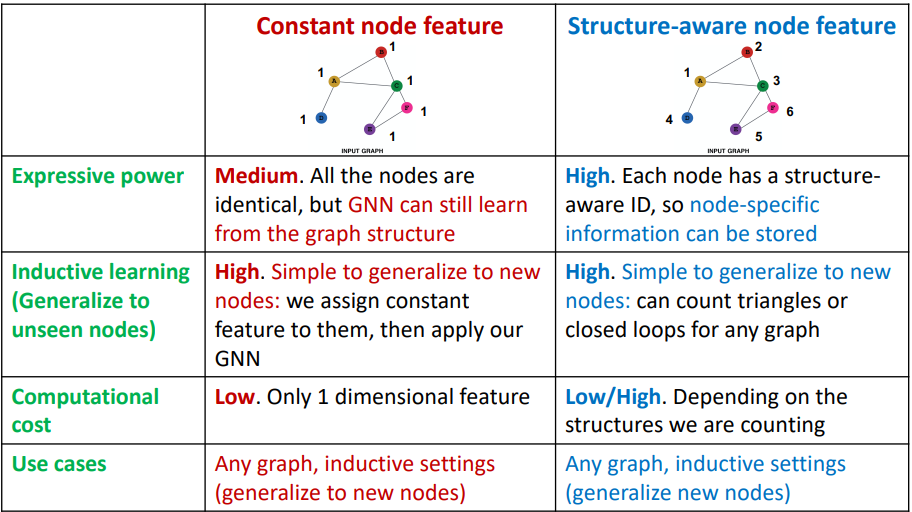


### Graph Structure Augmentation (graph streamlining)
Sparse graphs can be augmented by **adding virtual edges**, commonly done by connecting $N_2(v)$ directly to $v$ (instead of using $A$ for GNN computation, use $A+A^2$ instead); decreasing the required GNN depth to achieve the same level of expressability, and able to train it faster (more neighbours to aggregate from can increase complexity). This is commonly used for Bipartite graphs where connecting the 2nd hop nodes is equivalent to a projection. Another approach would be to **add virtual nodes** connecting all (or some carefully chosen subset of all) other nodes in the graph. This greately improving message passing in sparge graphs by creating paths of 2 between every node with any other node. 

For the opposite problem, too large and dense graphs, augmentations (most naive approach being **random sampling**) can be used to sample a node's neighborhood for message passing and thereby dgaining computational efficiency at a minimal loss of expressive power.

## GNN Training Pipeline
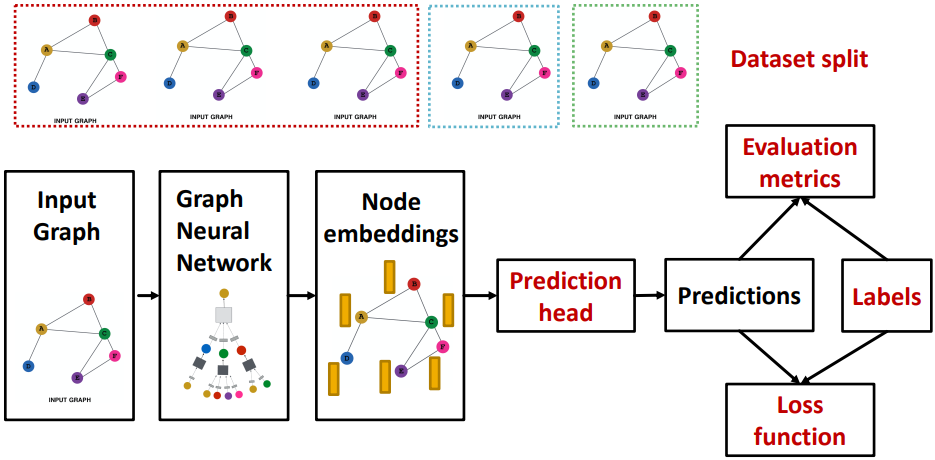

### Prediction Head
After the embeddings have been generated, the second part of the machine learning process needs to be defined; most importantly the process of transforming the given embeddings into a prediction, called the ***prediction head***. *Prediction head* is defined differently based on the graph task the GNN undertakes. 

*Nodel-level predictions* can be made directly using the node embeddings; taking the generated embedding (after the GNN computation), $\{h^{(0)}_v\in\mathbb{R}^d,\forall v\in G\}$, and calculating the prediction $\hat{y}_v=\text{Head}_{\text{node}}(h^{(0)}_v)=W^{(H)}h^{(0)}_v$ (classify among $k$ categories, or regresson $k$ targets), where $W^{(H)}\in\mathbb{R}^k\times\mathbb{R}^d$. This can naturally be substituted with any number of larger and more complex deep learning network architecture though will decrease computational efficiency at the potential increase in accuracy. 

*Edge-level predictions* require a pair of node embeddings to make a link prediction, $\hat{y}_{uv}=\text{Head}_{\text{edge}}(h^{(0)}_u, h^{(0)}_v)$. The simplest solution to this is to concatonate the embeddings and apply a linear predictor on top of it, $\hat{y}_{uv}=\text{Linear}({\text{Concat}}(h^{(0)}_u, h^{(0)}_v))$. Another way would be to perform a dot product between the embeddings, $\hat{y}_{uv}=(h^{(0)}_u)^{\text{T}}h^{(0)}_v$, which creates a 1-way prediction (predict existence of a link); and can be further expanded to apply to $k$-way predictions via (trainable) *multi-head attention*, $\{W^{(1)},\ldots,W^{(k)}\}$, such that
$$\hat{y}^{(0)}_{uv}=(h^{(0)}_u)^{\text{T}}W^{(1)}h^{(0)}_v,\;\ldots,\;\hat{y}^{(k)}_{uv}=(h^{(0)}_u)^{\text{T}}W^{(k)}h^{(0)}_v$$
$$\hat{y}_{uv}=\text{Concat}(\hat{y}^{(0)}_{uv},\ldots,\hat{y}^{(k)}_{uv})\in\mathbb{R}^k$$

*Graph-level predictions* utilises all node embeddings in the graph to make a prediction, $\hat{y}_G=\text{Head}_{\text{graph}}(\{h^{(0)}_v\in\mathbb{R}^d,\forall v\in G\})$, and thus $\text{Head}_{\text{graph}}(\cdot)$ is similar to $\text{AGG}(\cdot)$ in a GNN layer. There are many options in choosing the prediction head for this prediction graph, most notably:
1. **Global mean pooling**: $\hat{y}_G=\text{Mean}(\{h^{(0)}_v\in\mathbb{R}^d,\forall v\in G\})$
2. **Global max pooling**: $\hat{y}_G=\text{Max}(\{h^{(0)}_v\in\mathbb{R}^d,\forall v\in G\})$
3. **Global sum pooling**: $\hat{y}_G=\text{Sum}(\{h^{(0)}_v\in\mathbb{R}^d,\forall v\in G\})$

which work great for small graphs but decrease in accuracy as the graph increases in size (over-smoothing). A more advanced solution would be to perform a hierarchical  pooling; where instead of aggregating all nodes at the same time, subsets of the nodes and aggregates are recursively pooled until a single result is generated.

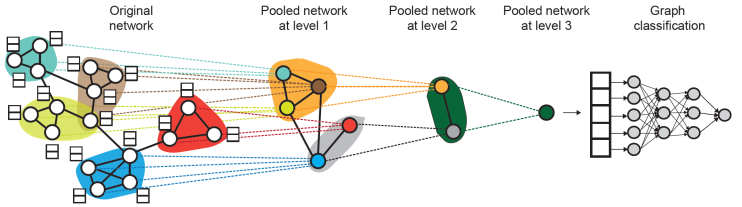

An issue then arises as to defining the subsets of nodes to first aggregate and then the process of hierarchically aggregating further. This can be solved by leveging 2 independent GNNs at each level; **GNN A** which computes the node embeddings, and **GNN B** which computes the clusters that the nodes belong to. These can be jointly trained, and executed in parallel. And such, for each pooling layer, **GNN B**'s clustering assignments will be used to aggregate the node embeddings generated by **GNN A** to create a single new node for each cluster while maintianing edges between clusters, and thus generate a new pooled network.

All processes after the *prediction head* are identical to the standard deep learning problem and as such GNN machine learning can work in both a *supervised* or *unsupervised* (self-supervised) fashion; and while both are formulated as an optimisation task (both need something to compare against), *supervised* recieves its ground truth external to the graph while *unsupervised* gaines it from within the graph (need to find supervision signals within the graph).
- See other notes on deep learning.

### Dataset Split
In standard machine learning model development, the dataset is split into a **training** (for optimizing model parameters), **validation** (for developing model hyperparameters), and **test** (final performance report) sets. For standard data types (files, tables, images, etc.), each data point is independent of each other and splitting can be naively done; however with GNNs, the entire dataset can be a single graph (can also be several) where each data point is related to others and so a different approach needs to be taken.

#### Node-level
In order to make a dataset split for node-level tasks is to obscure the labels of some of the data for each step; which can be done in one of 2 ways:

One way to accomplish dataset split is through **transductive setting**; where the input graph can be observed in all the dataset splits with the exception to the node labels (at *training time*, embeddings will be done using the entire graph structure but only the *training set*'s labels, etc.). This method is applicable to both node and edge predictions.

The other method is the **inductive setting**; which breaks the edges between splits to get multiple smaller but independent graphs. The procedure after this is then very similar to that of standard model development. This method is also applicable to node, edge, and graph predictions.

#### Edge-level
Setting up link prediction is more difficult as it is an unsupervised task, and so dataset split must be done as well as creating labels to optimise against. Labels can be created by hiding some edges from the GNN and then letting the GNN predict if they exist or not; thus each edge must be assigned as either a **message passing** or **supervision** edge. After this, all *supervision* edges are removed and will not be fed into the GNN, only used to supervision for edge predictions made by the model. Then, a second split needs to be done to seperate the dataset into *training*, *validation*, and *test* sets, which can be done by either the *inductive* or *transductive* setting. The *inductive* setting is straight forward splitting the dataset further and having the sets be independently used.

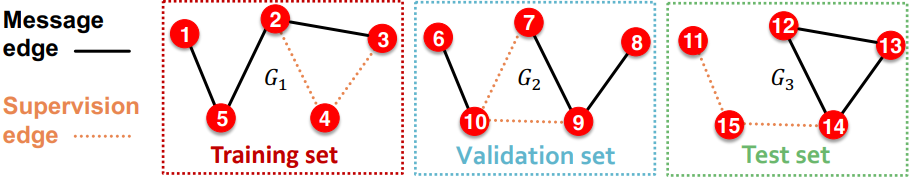

The *transductive* setting however, is more complex, requiring *validation*, and *test* edges to be held out of the full graph to prevent data leakes; and in addition, the *supervision* edges are also removed for the training of the model itself. This allows for an iterative process where as the model development progresses through the *training*, *validation*, and *test* phases, additional edges are added back into the graph. This is done as after each step, the *supervision* edges used are known to the mode, and idealy should then be used in the following step predictions.

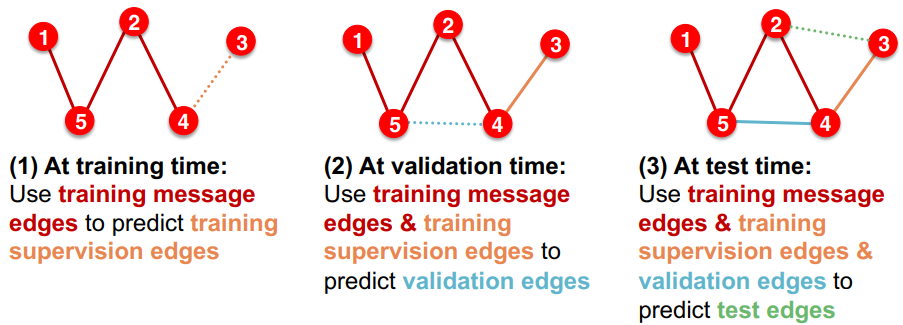

## Expressiveness of GNN
The key idea of graph neural networks is aggregating (using neural networks) local network neighborhoods around a given node of interest to generate its embedding, and so to explore how effective this idea is, and in turn how expressive GNNs are, the following question needs to be answered. How well can GNNs distinguish different graph structures (if have different features it is easier to distinguish and thus does not help with the exploration), specifically considering only the local neighborhood structures around each node in a graph (if entire graph is considered, then distinction is trivially done). 

A GNN generates node embeddings through a computational graph defined by the neighborhood and its node features, disregarding the node *ids*; and so structures which differ only in the node *ids* (same computational graph structure and node features) will be considered identical from the perspective of the computational graph.

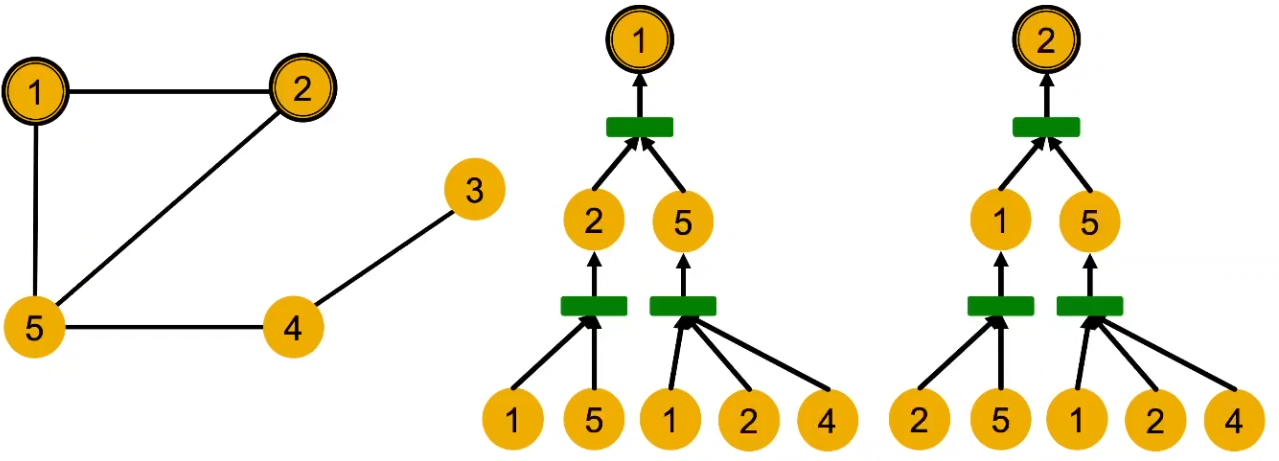

So the most, possible expressive GNN will be able to map different *rooted subtrees* ($k$ layer tree rooted at node of interest with its children beign the parent's neighbors) into differente node embeddings. This means that the most expressive GNN should map subtrees to the node embedding space through an ***injective*** function (maps distinct elements in its domain to distinct elements of its codomain), $f:X\rightarrow Y$, with $f$ intuatively retaining all information about its input.

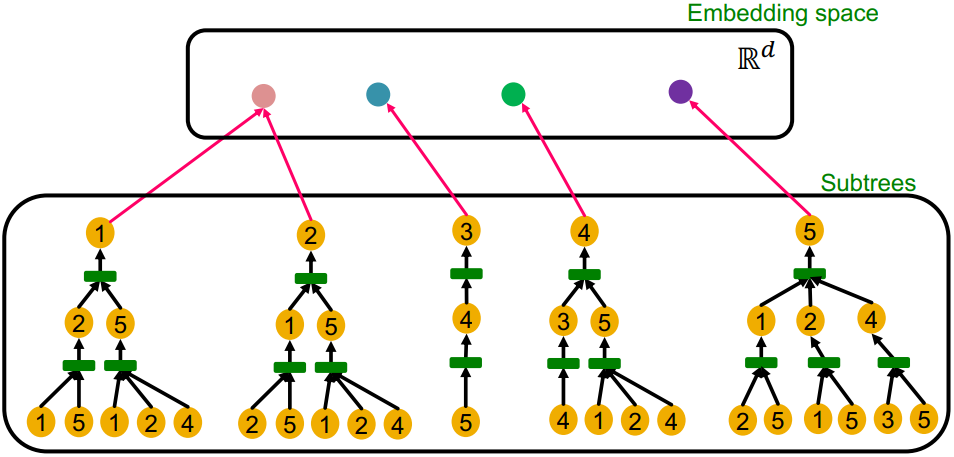

As the subtrees of the same depth can be recursively characterized from the leaf nodes to the root nodes, if each step of a GNN's aggregation (can then be abstracted to a function over a multi-set, a set with repeating elements) is *injective* (fully retain the neighboring information), the generated node embeddings can distinguish different *rooted subtrees*.

GCN uses element-wise mean pooling over neighboring node features to aggregate neighborhoods, $\text{Mean}(\{x_u\}_{u\in N(v)})$ followed by a ReLU function, $\max\{0, x\}$; while GraphSAGE uses element-wise max pooling, $\text{Max}(\{x_u\}_{u\in N(v)})$. This therefore means that GCN's aggregation function cannot distinguish between different multi-sets with the **same color proportions**; while GraphSAGE's cannot distinguish between different multi-sets with the **same set of distinct colors**. It can then be seen that neither GCN or GraphSAGE aggregation functions are injective, and so are not maximally powerful GNNs.

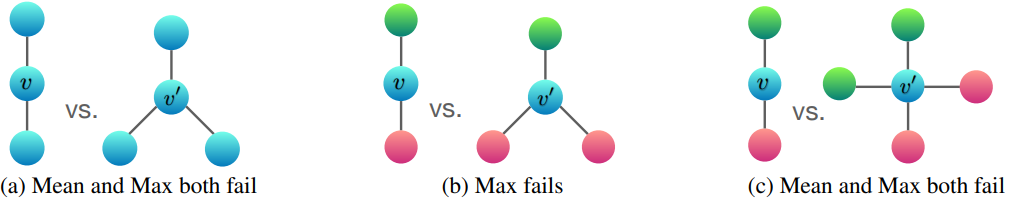

Using the theorem **"any injective multi-set function can be expressed as $\Phi(\sum_{x\in S}f(x))$, where both $\Phi$ and $f$ are non-linear functions"** (can be intuatively seen by $f(x)$ being injective in relations to nodes and seperating the colors enough so when they are summed, a distinct result is entered into $\Phi$ which then does the same on the neighborhood level), an injective neighborhood aggregation function can be designed. Additionally, by the Universal Approximation Theorem; **"a 1-hidden-layer Multi-Layer-Preceptron with sufficiently larger hidden dimensionality and appropriate non-linearity $\sigma(\cdot)$ (including ReLU and sigmoid) can approximate any continuous function to an arbitrary accuracy."**, it means that $\text{MLP}_{\Phi}(\sum_{x\in S}\text{MLP}_{f}(x))$ can model any injective multiset function (In practice, MLP dimensionality of 100-500 is sufficient).

### Graph Isomorphism Netwrok (GIN)
The GNN which uses this injective aggregation function is called *GIN*, and is the most expressive GNN in the class of message-passing GNNs. In essence, *GIN* is the "neural network" version of the *WL graph kernel* (traditional way of obtaining graph-level features); which iteratively refines node colors by re-assigning them $c^{(k+1)}(v)=\text{HASH}(c^{(k)}(v),\{c^{(k)}(u)\}_{u\in N(v)})$, and after $K$ steps of color refinement, each color $c^{(K)}(v)$ summarizes the structure of $v$'s $K$-hop nieghborhood. $\text{HASH}$ functions are as injective as possible as they are precisely defined to minimise collisions; and so it can be $c^{(k+1)}(v)=\text{HASH}(c^{(k)}(v),\{c^{(k)}(u)\}_{u\in N(v)})$ can eb modeled using *GIN* as  $c^{(k+1)}(v)=\text{MLP}_{\Phi}((1+\epsilon)\text{MLP}_{f}(c^{(k)}(v))+\sum_{u\in N(v)}\text{MLP}_{f}(c^{(k)}(u)))$ where $\epsilon$ is a learnable scalar.

It can be additionally seen that if $c^{(0)}(v)$ is represented as one-hot (or similar definitions), direct summation is injective ($(1,0)+(1,0)+(0,1)=(2,1)$, etc.). This means that only $\Phi$ is needed to ensure the injectivity, and thus a simpler *GIN* convolutional layer can be defined as $\text{GINConv}(\{c^{(k)}(v),\{c^{(k)}(u)\}_{u\in N(v)}\})=\text{MLP}((1+\epsilon)c^{(k)}(v)+\sum_{u\in N(v)}c^{(k)}(u))$. And so, given a graph $G$ with a set of $V$ nodes, assigning an initial vector $c^{(0)}(v)$ to each and iteratively updating the vectors by $c^{(k+1)}(v)=\text{GINConv}(\{c^{(k)}(v),\{c^{(k)}(u)\}_{u\in N(v)}\})$; after $K$ steps of *GIN* iterations, $c^{(K)}(v)$ summarizes the structure of $v$'s $K$-hop nieghborhood.

*GIN*'s close relationship with *WL graph kernel* (very powerful model) means that their expressiveness is exactly the same; if two graphs can be distinguished by *GIN*, they can be also distinguished by *WL kernel* and vice versa.

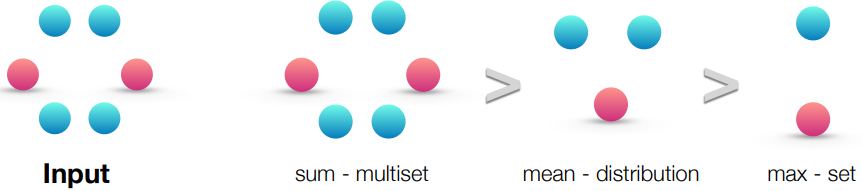

#### Matrix Representation
By simply expanding the *GIN* layer $c^{(k+1)}(v)=\text{MLP}((1+\epsilon)c^{(k)}(v)+\sum_{u\in N(v)}c^{(k)}(u))$ to $\text{MLP}_{-1}(\sigma(W^{(k)}(1+\epsilon)c^{(k)}(v)+\sum_{u\in N(v)}W^{(k)}c^{(k)}(u)))=\text{MLP}_{-1}(\sigma(W^{(k)}_0c^{(k)}(v)+\sum_{u\in N(v)}W^{(k)}_1c^{(k)}(u)))$ where $\text{MLP}_{-1}$ denotes all the MLP layers except the first. Given then that $C^{(k)}\in\mathbb{R}^N\times\mathbb{R}^d$, $C^{(k)}[v,:]=c^{(k)}(v)$, and $A\in\{0,1\}^N\times\{0,1\}^N$ is the adjacency matrix of the graph, the function can be re-written in a matrix form as $$C^{(k+1)}=\text{MLP}_{-1}(\sigma(C^{(k)}W^{(k)}_0+AC^{(k)}W^{(k)}_1))=\text{MLP}_{-1}(\sigma(\sum_{l=0}^{1}A^lC^{(k)}W^{(k)}_l))$$


Given a real, symmetric, matrix ($\bar{A}^{\text{T}}=A$) $A$. Its eigenvalues are real (given $Ax=\lambda x$, $A\bar{x}=\bar{\lambda}\bar{x}\rightarrow\bar{x}^{\text{T}}A=\bar{x}^{\text{T}}\bar{\lambda}$ and so both $\bar{x}^{\text{T}}Ax=\bar{x}^{\text{T}}\lambda x$ and $\bar{x}^{\text{T}}Ax=\bar{x}^{\text{T}}\bar{\lambda}x$ meaning that $\lambda=\bar{\lambda}$ and so is real) and the corresponding eigenvectors can be chosen as orthogonal:
- If $\lambda$s are distinct, their corresponding $q_{(i)}$ are orthogonal. Let $Ax=\lambda x$ and $Ay=\mu y$ such that $\lambda \neq \mu$, then $\lambda x \cdot y=Ax\cdot y = x^{\text{T}}A^{\text{T}}y=x\cdot Ay = x\cdot \mu y \rightarrow (\lambda - \mu)x\cdot y = 0$  and so $x$ is orthogonal to $y$.
- If $\lambda$ repeats, there's a plane of corresponding $q_{(i)}$ and can so be chosen such that they are orthogonal (Gram-Schmidt Process).

$$Aq_{(i)}=\lambda_{(i)} q_{(i)}\rightarrow AQ=Q\Lambda\rightarrow A=Q\Lambda Q^{-1}$$
$$\therefore A^k=Q\Lambda^k Q^{-1}$$

Additionally, $A=Q\Lambda Q^{-1}\rightarrow A^{\text{T}}={Q^{-1}}^{\text{T}}\Lambda^{\text{T}} Q^{\text{T}}$; and as $\Lambda$ and $A$ are symmetric, $A={Q^{\text{T}}}^{-1}\Lambda Q^{\text{T}}$ and so $Q\Lambda Q^{-1}={Q^{\text{T}}}^{-1}\Lambda Q^{\text{T}}$ which is only possible if $Q^{-1}=Q^{\text{T}}$. Therefore, $A=Q\Lambda Q^{\text{T}}=\sum_{i=1}^{n}\lambda_{(i)}q_{(i)}q^{\text{T}}_{(i)}$ such that $\lambda_{(1)}\geq\ldots\geq\lambda_{(n)}$ and $\text{Eig}_{\lambda_{(i)}}(A)=q_{(i)}$


The eigenvalue (spectral) decomposition of the adjacency matrix is a universal characterization of the graph; where different graphs have different spectral decompositions. Additionally, the number of cycles in a graph can be viewed as a function of eigenvalues and eigenvectors ($\text{\#triangles}=\text{diag}(A^3)=\sum_{n=1}^N\lambda_n^3|q_n|^2$). This meanst that *GIN* layers can be interpreted as MLPs operating on eigenvectors if $A$ is replaced with $A=Q\Lambda Q^{\text{T}}$:
$$C^{(k+1)}=\text{MLP}_{-1}(\sigma(\sum_{l=0}^{1}(Q\Lambda Q^{\text{T}})^lC^{(k)}W^{(k)}_l))=\text{MLP}_{-1}(\sigma(Q\mathbb{W}))$$
$$\mathbb{W}[n,f]=\sum_{i=1}^d\sum_{l=0}^1\lambda_{(n)}^lW_l[i,f](q_{(n)}^{\text{T}}C^{(k)}[:,i])$$
And so it can be seen that the weights of the first MLP layer depend on the eigenvalues and the dot product between the eigenvectors and the coloers at the previous level. As initially all nodes begin with color $1$ (otherwise cannot maintain consistency of process across different graphs, etc.) and so $\mathbb{W}[n,f]=\sum_{i=1}^d\sum_{l=0}^1\lambda_{(n)}^lW_l[i,f](q_{(n)}^{\text{T}}1)$ and so the new node colors only depend on the eigenvectors that are not orthogonal to $1$ (else will be $0$). 

As stated above, matrix decomposition obtains eigenvectors as being orthogonal to each other and further, graphs with symmetries admit eigenvectors orthogonal to 1; meaning that critical spectral components are ommitted in the message-passing operations due to them being orthogonal to the initial node color (limiting factor), causing limitted representations, constant node colorings, and the inability to distinguish between some graph structures, or count basic graph structures.

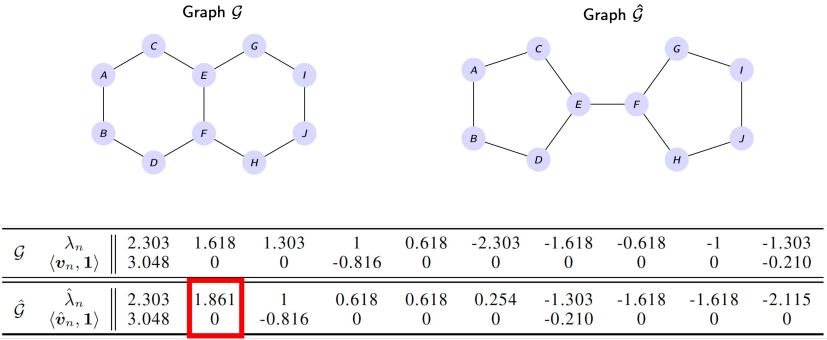

This specific limitation applies to *WL graph kernel* (and *GIN* which emulates it); however, consider the GNN model where each layer is defined as $c^{(k+1)}(v)=\text{Linear}((1+\epsilon)c^{(k)}(v)+\sum_{u\in N(v)}c^{(k)}(u))$ and the last layer has the non-linear function, $\sigma(\cdot)=(\cdot)^2$ (square pointwise nonlinearity function), apply $c^{(K)}(v)=\sigma(c^{(K)}(v))$; if then it is applied onto nodes whose colors are represented injectively, it realises the injective theorem (as stated above) and therefore is a *GIN* layer. Representing node ids as random samples will cause the *GIN* model to produce different results $y^{(1)},y^{(2)},\ldots,y^{(n)}\overset{\text{iid}}{\sim}Y$ every runs (new samples), and though each result is independent and identically distributed; the underlying distribution has the graph's structural information, and so the final result can be a statistic of it $$y=\mathbb{E}[y^{(m)}]\rightarrow y=\frac{1}{M}\sum_{m=1}^{M}y^{(m)}$$
It can be seen that the previous procedure computes the closed loops of a graph $C^{(0)}=[\text{diag}(A^{0}),\text{diag}(A^{1}),\text{diag}(A^{2}),\ldots,\text{diag}(A^{D-1})]\in\mathbb{N}_0^N\times\mathbb{N}_0^D$ and thus it can break the limitations of the *WL graph kernel* and count importatn substructures in the graph.

### Position Aware Tasks
Upto now, all tasks investigated so far were **"structure aware"** tasks; where a GNN constructs different computation graphs for nodes which are structurally different from each other (assuming most difficult situation where all nodes have the same feature). However **"position aware"** tasks; where different nodes in different positions on the graph have identical computation graphs will always cause GNN to fail, as there is no distinguishing features between them. It is possible however to define deep learnign methods that are position ware.

<table><tr><td>

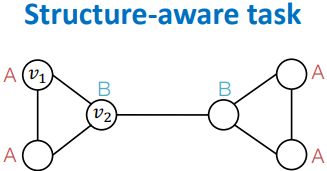
</td><td>

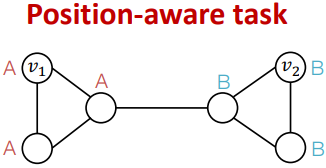
</td></tr></table>

#### ***Anchor***
A simple method can be logically defined by randomly picking a node $s_1$ as an *anchor node*, with all all other nodes being defined via their relative distance with relations to the *anchor*; thereby serving as a coordinate axis (can be used to locate nodes in the graph). It can also be observed that more *anchors* can better characterize node positions in different regions (increase coordinate axes).

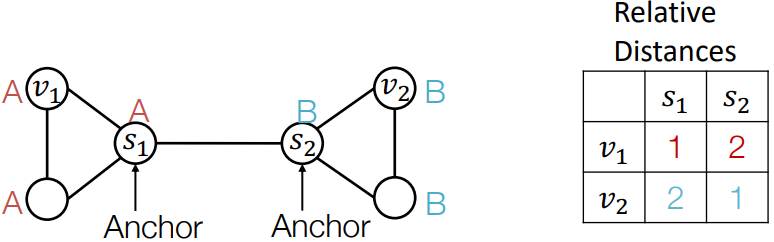

This can then be generalized into defining not only one node as and *anchor* but also sets of nodes as an *anchor set*; where the distance to an *anchor set* is the minimum distance to all the nodes in the set.

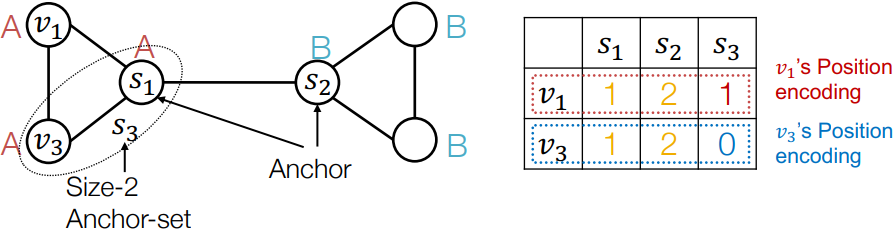

What this does in essence is to embed the metric space $(V,d)$ into the euclidian space $\mathbb{R}^k$ such that the original distance metric is preserved; for every node pairs $u,v\in V$, the euclidian embedding distance $||z_u-z_v||_2$ is close to the original distance metric $d(u,v)$. A rigorous definition is provided by the **Bourgain Theorem** for an embedding function which produces embeddings which are provably close to the original distance metric: $$f(v)=(d_{\min}(v,S_{1,1}),d_{\min}(v,S_{1,2}),\ldots,d_{\min}(v,S_{\log n,c\log n}))\in\mathbb{R}^{c\log^2n}$$where $c$ is a constant, $S_{i,j}\subset V$ is chosen by including each node in $V$ independently with probability $\frac{1}{2^i}$ and $d_{\min}(v,S_{i,j})\equiv \min_{u\in S_{i,j}}d(u,v)$.

This definition is used in the *P-GNN* model, which first samples $O(\log^2n)$ *anchor* sets $S_{i,j}$ and embed each node $v$ as $(d_{\min}(v,S_{1,1}),d_{\min}(v,S_{1,2}),\ldots,d_{\min}(v,S_{\log n,c\log n}))\in\mathbb{R}^{c\log^2n}$. During training, new *anchor sets* are re-sampled every time to ensure *P-GNN* maintains the inductive capability and learns to operate over unseen sets (will be done at test time).

While the simplest way to use this position aware encoding is to use it as an augmented node feature (works well in practice), since each dimension of position encoding is tied to a random *anchor set*, dimensions of positional encoding can be randomly permuted without changing its meaning. It therefore, requires a special nueral network, for a rigorous solution, that can maintain the permutation invariant property of position encoding (permutation of input feature dimension will only result in the permutation of the output dimension). More information in https://arxiv.org/pdf/1906.04817.

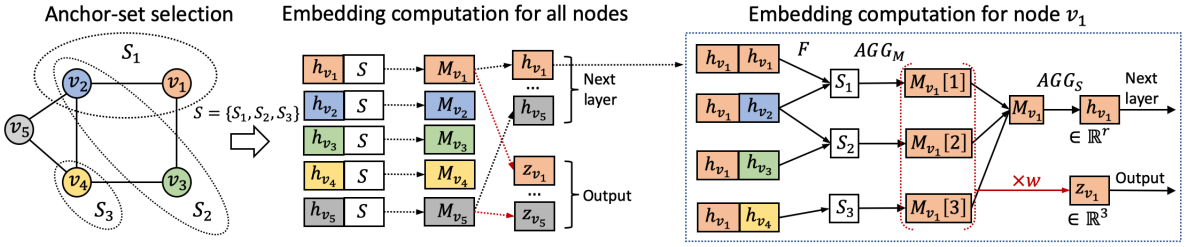

# Graph Transformers
## The Transformer
Pre 2017, the dominant *sequence transactions* (process of transforming a sequence of inputs to a sequence of outputs - language translate, etc.) models were based on complex *recurrent* or *convolutional* neural networks that include an encoder and a decoder; with the best performing ones incorporate in conjunction *attention mechanisms* (concepts of modeling dependencies without regard to their distance in the input or output sequence). Introduced in 20217 (https://arxiv.org/pdf/1706.03762), the ***Transformer*** utlises exclusively *attention mechanisms* (and tranditional neural networks) to draw global dependencies between input and output; thereby allowing for significantly more parallelization (as opposed to recurrent NNs, etc.).
### Architecture
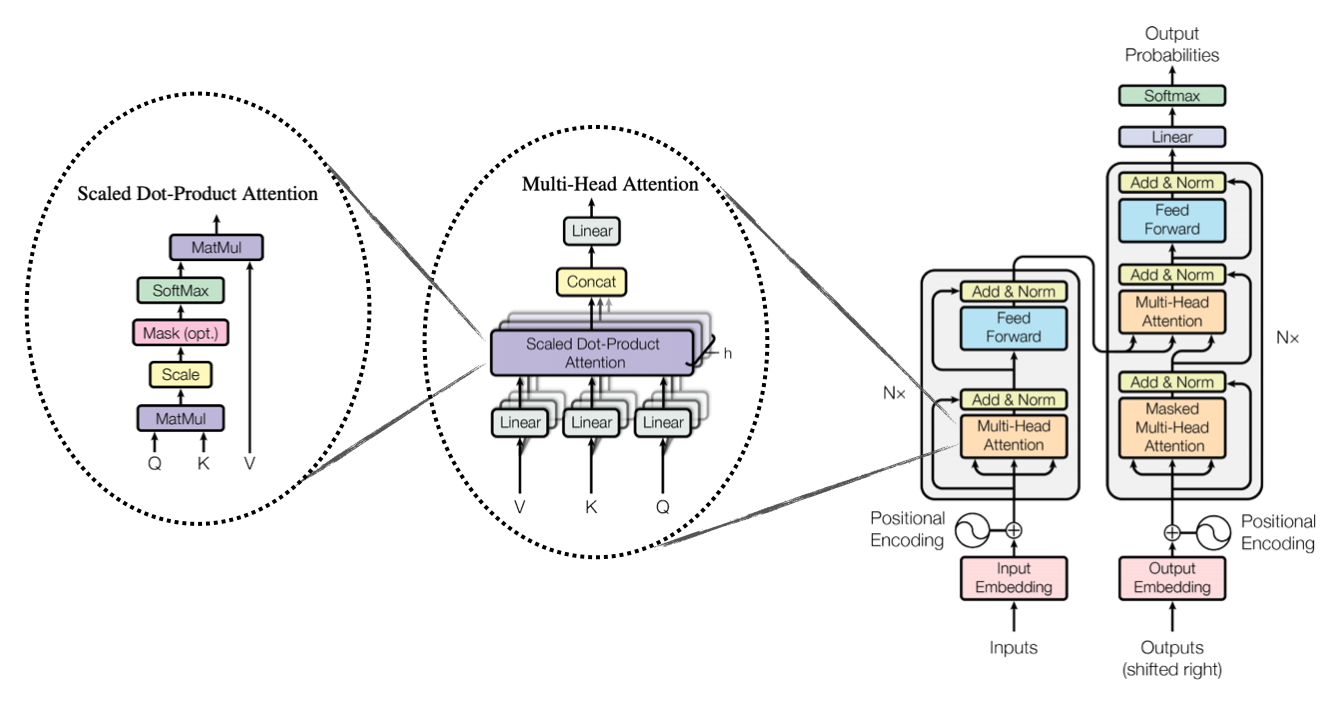

*Transformers* map an input sequence of symbol representations $(x_1,\ldots,x_n)$ (known as tokens - "pieces" of data) to a sequence of continuous representations $z=(z_1,\ldots,z_n)$; and given $z$, the decoder then generates an output sequence $(y_1,\ldots,y_m)$ of symbol representations - one element at a time. At each step the model is auto-regressive, consuming the previously generated symbols as additional input when generating the next.

#### Encoder
The *encoder* is composed of a stack of $N$ (original paper $N=6$) identical layers, each with 2 sublayers; a *multi-head self-attention* mechanism, and a simple position-wise fully connected *feed forward* neural network. Each sublayer additionally has a *skip connection* followed by a *layer normalization*.
$$\text{LayerNorm}(x+\text{Sublayer}(x))$$
This is facilitated by the all sublayers in the model (as well as embedding layers) produce outputs of dimension $d_{\text{model}}$ (original paper $d_{\text{model}}=512$).

#### Decoder
The *decoder* is also composed of a stack of $N$ identical layers; and in addition to the two sublayers in each *encoder* layer, the decoder inserts a 3rd sublayer which performs a *multi-head attention* over the output of the *encoder* stack. Similarly, each sublayer additionally has a *skip connection* followed by a *layer normalization*. The 1st sublayer (*multi-head attention*) is additionally modefined in the *decoder* stack to prevent positions from attending to subsequent positions; which combined with combined with the fact that the output embeddings are offset by 1 position, ensures that the predictions from position $i$ can depend only on the known outputs at positions $<i$.
#### Attention Mechanism
An attention mechanism can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and outputs are all vectors. The output is computed as a weighted sum of the values, where the *weight* assigned to each value is computed by a *compatibility function* of the query with the corresponding key. 

This therefore is reliant on *compatability functions* capturing important relationships between keys and queries. *Word/token/text embeddings* (*Word2Vec*, etc.) are designed to maintian the semantic relationship/similarity which the original words/tokens had in the new vector space. This then means that words/tokens which are similar to one another would be close to each other in the new embedding space, and so a simple *dot product* can be used to measure the embedding similarities between a query and a key due to $\vec{q}\cdot\vec{k}=|\vec{q}||\vec{k}|\cos{\theta}$. Additionally, *vector addition* can also be used to measure embedding similarities as $\vec{c}=\vec{q}-\vec{k}\rightarrow \vec{c}\cdot\vec{c} = (\vec{q}-\vec{k})\cdot(\vec{q}-\vec{k})=c^2=|\vec{q}|^2+|\vec{k}|^2-2|\vec{q}||\vec{k}|\cos{\theta}$.

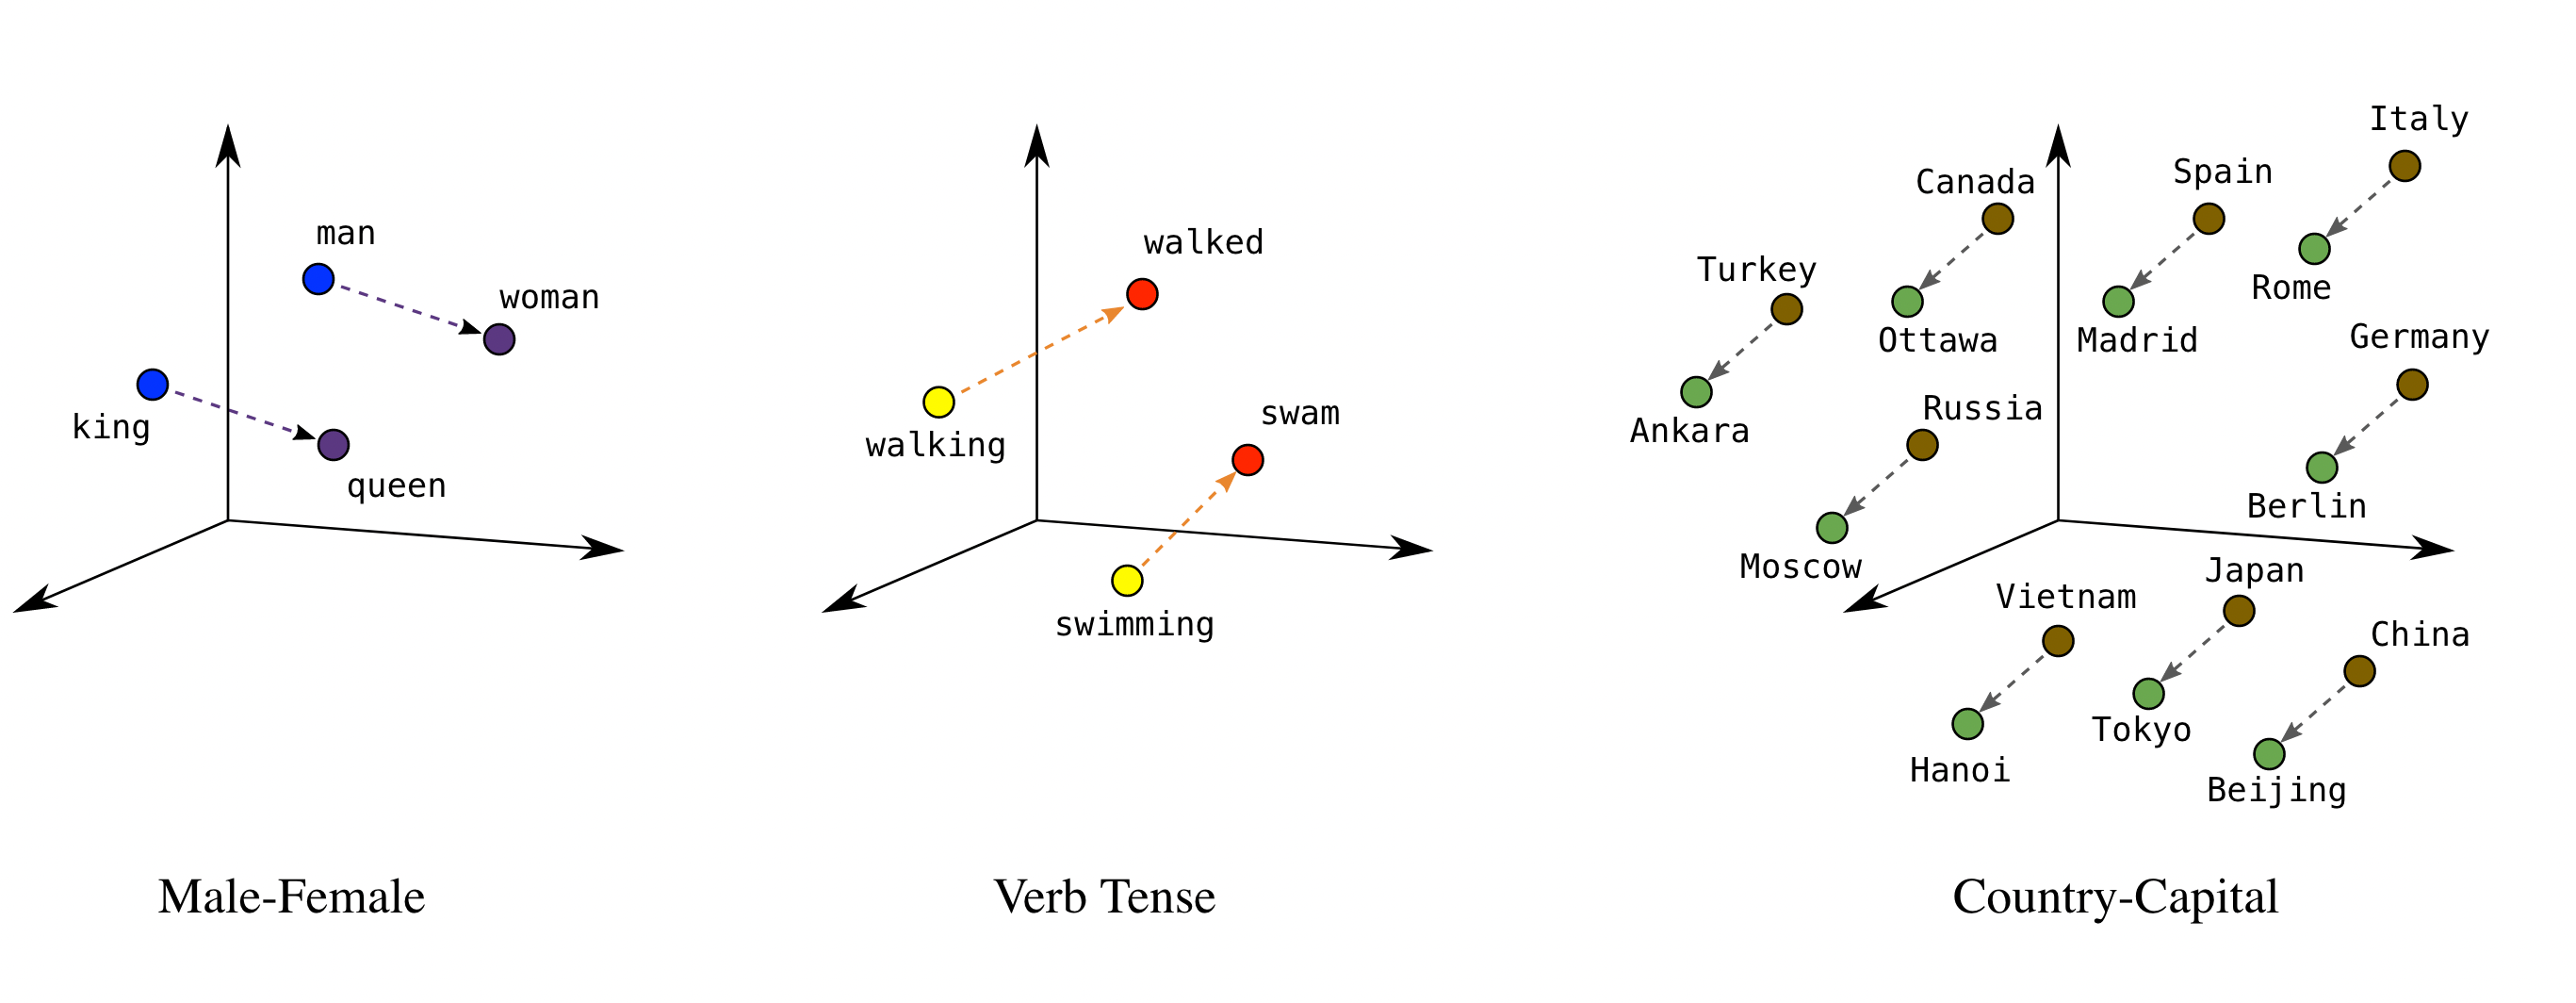

##### Multi-Head Attention
The input embeddings $(x_1,\ldots,x_n)$ are computed, via learned linear transformations, into queries $Q=(q_1,\ldots,q_n)$ and keys $K=(k_1,\ldots,k_n)$ of dimension $d_{k}$, and values $V=(v_1,\ldots,v_n)$ of dimension $d_{v}$ (using model parameters $W^Q$,$W^K$, and $W^V$ respectively). The *dot products* of each query (in practice, done simultaneously with $Q$ instead of $\forall q_i$) with all keys are then computed (*compatibility function*) and divided by $\sqrt{d_k}$ (counteract *dot products* growing in magnitude and pushing *softmax* in small gradient regions) and have a *softmax* function applied to obtain the *weights* on the values.
$$\text{Attention}(Q,K,V)=\text{Softmax}(\frac{QK^{\text{T}}}{\sqrt{d_k}})V$$
$Q=XW^Q$, $K=XW^K$, $V=XW^V$

Instead of perfroming a single attention function with $d_{\text{model}}$-dimensional keys, values and queries, it was found that it is beneficial to linearly project the keys, values and queries $h$ times with different, learned linear projections to $d_{k}$, $d_{k}$, and $d_{v}$ dimension respectively (using model parameters $W^Q_i$,$W^K_i$, and $W^V_i$ respectively for $\forall i\in\{1,\ldots,h\}$). On each projection the *attention function* can then be performed in parallel, withthe output values being concatonated and again projected, resulting in the final value. 
$$\text{MultiHead}(Q,K,V)=\text{Concat}\left({\text{Attention}(Q_1,K_1,V_1),\ldots,\text{Attention}(Q_h,K_h,V_h)}\right)W^O$$
$Q_i=XW_i^Q$, $K_i=XW_i^K$, $V_i=XW_i^V$

### Positional Encoding
Since the model contains no reccurence and no convolution, in order for the model to make use of the order of the sequence (outside of masking), some information must be injected about teh relative/absolute position of the token in the sequence; and so *positional encoding* is added to the input embeddings at the bottomes of the *encoder* and *decoder* stacks with same dimensionality as the embedding so teh two can be summed.
$$\text{PE}_{(pos,2i)}=\sin(pos/10000^{2i/d_{\text{model}}})$$
$$\text{PE}_{(pos,2i+1)}=\cos(pos/10000^{2i/d_{\text{model}}})$$

## Graph Transformers
GNNs also take in a sequence of vectors (in no particular order) and output a sequence of embeddings; the difference being that GNNs use message passing, and Transformers use self-attention.

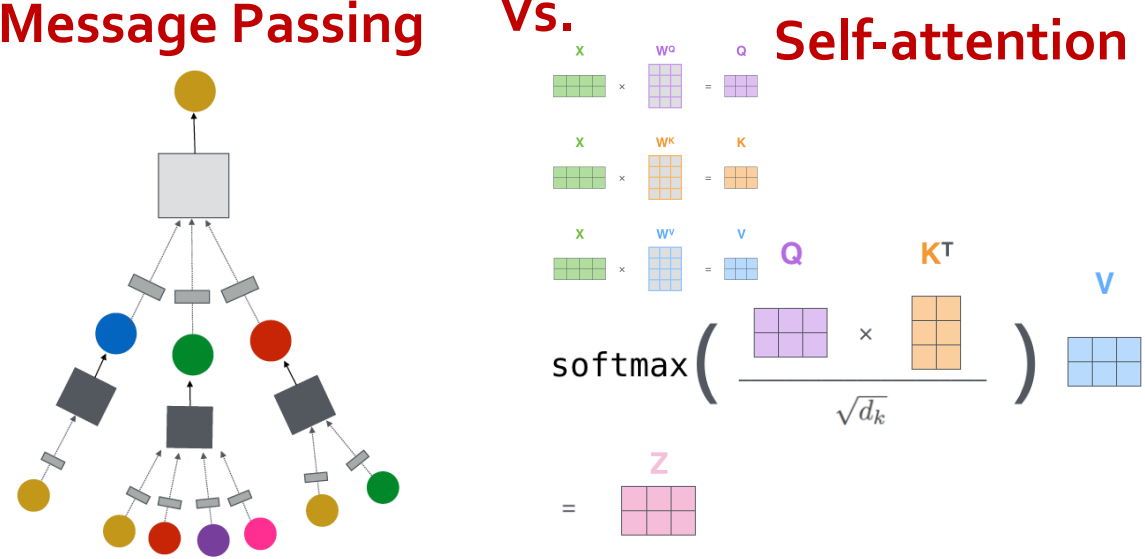

If self-attention is considered a token at a time, then $z_i=\sum_{j=1}^N\text{Softmax}(\frac{q_ik_j}{\sqrt{d_k}})v_j$ and this can be re-written as a message step $(v_j,k_j)=\text{MSG}(x_j)=(W^Vx_j,W^Kx_j)$, $q_i=\text{MSG}(x_i)=W^Qx_i$,and an aggregation step $\text{Agg}(q_i,\{\text{MSG}(x_j):j\})=\sum_{j=1}^N\text{Softmax}(\frac{q_ik_j}{\sqrt{d_k}})v_j$. This is then can be thought of as a GNN where each token is a node in a fully connected graph (token $i$ depends on all other tokens). Alternatively, if the sum is done only over $j\in N(i)$, it is approximately a *GAT*.

### Laplacian Matrix
https://arxiv.org/pdf/2106.03893. This does not include however the node positions, and will result in different structures to result in the same output (bag-of-word model, etc.) if the node features are identical. Therefore, positional encoding (learnable) is required to ensure that the modle structure is learned; and while there are many ways of achieving this, a popular method is to encode the adjacency matrix of the graph as positional encodings and combined with the node features create a token. This can be additionally done via relative distances (discussed above). Further, positional encoding can be achieved through the ***Laplacian Eigenvectors***, the *eigenvectors* corresponding to the *Laplacian matrix* $L=\text{Diag}(d_1,\ldots,d_N)-A$ ($A$ is the adjacency matrix); each graph has its own $L$ which encodes the graph structure.

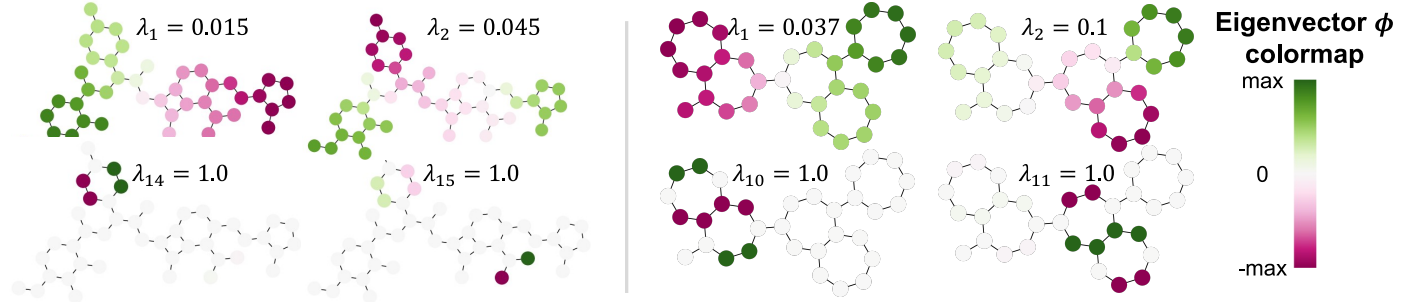

$L$'s eigenvectors inherit this structure (small eigenvalue - global structure, large eigenvalue - local symmetries) and thereby can be used to generate positional encoding by concatonating all $k$ eigenvectors and defining  $i^{th}$ row as the $i^{th}$ tokens' positional encoding.

There is $2^k$ different sign choices ($2^k$ different predictions for the same input graph) for the $k$ eigenvectors (as $Lv=\lambda v$ and $L(-v)=\lambda(-v)$). If then a different sign is chosen, a different prediction will be generated, and so a sign invariant solution should be chosen. A straightforward method would be to randomly flip the signs during training, but this is very difficult to learn due to exponentially many sign choices; and a better one would be building a neural network that is invariant to sign choices ($f(v_1,v_2,\ldots,v_n)=f(\pm v_1,\pm v_2,\ldots,\pm v_n)$ and needs to be "expressive")
- $f(v)=\phi(v)+\phi(-v)\rightarrow f(-v)=\phi(-v)+\phi(v)=f(v)\rightarrow \text{let }\phi(v)=f(v)/2\rightarrow \phi(v)+\phi(-v)=f(v)/2+f(v)/2=f(v)$. Therefore $f$ satisfies $f(v)=f(-v)$ if and only if there is a $\phi$ such that $f(v)=\phi(v)+\phi(-v)$; and so, let the final model be $f(v_1,\ldots,v_k)=\Phi(\phi(v_1)+\phi(-v_1),\ldots,\phi(v_k)+\phi(-v_k))$, where $\Phi$ and $\phi$ are any neural network (https://arxiv.org/pdf/2202.13013). Thereby, $f$ will be expressive as it can express all sign invariant functions.

### Modified Attention
The only structure within a graph left to add to the transformer are the edge features. These can be added onto the self-attention mechanims by implementing edge feature dependent weightings, $C$, be inserted into $\text{Attention}(Q,K,V)=\text{Softmax}(\frac{QK^{\text{T}}}{\sqrt{d_k}}+C)V$; where if there is an edge between $i$ and $j$ with features $e_{ij}$, $c_{ij}=w_1^{\text{T}}e_{ij}$, and if there is no edge, and the shortest path between $i$ and $j$ is $(e^{(1)},\ldots,e^{(n)})$ then $c_{ij}=\sum_nw_n^{\text{T}}e^{(n)}$ ($w_1,\ldots,w_n$ are learned parameters)

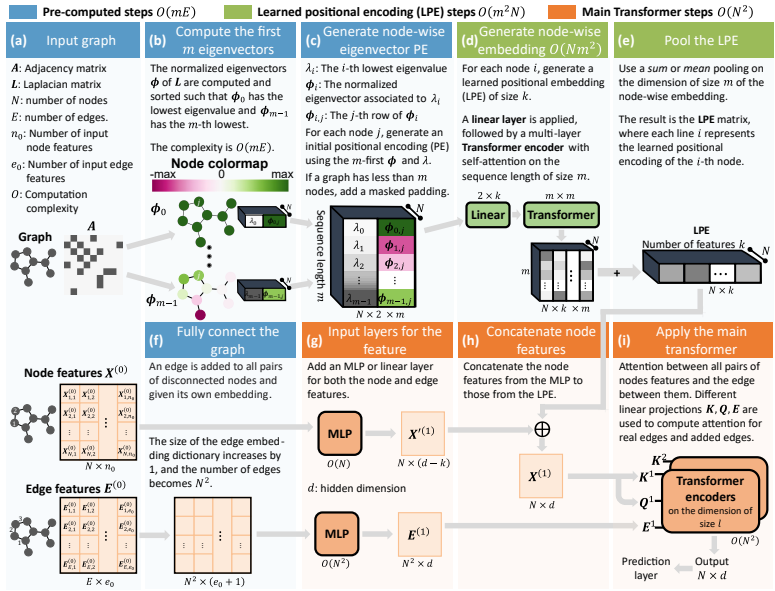